<a href="https://colab.research.google.com/github/Lanxin-Xiang/is765/blob/main/W4b_Language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W4. Language modeling

Ref:

https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/lectures/vanishing_grad_example.html

https://www.deeplearningbook.org/contents/rnn.html

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275

Deep Learning with Python, Second Edition, Chapter 5, 7

## Recurrent Neural Network

Recurrent neural networks, or RNNs (Rumelhart et al., 1986a), are a familyof neural networks for processing sequential data. To go from multilayer networks to recurrent networks, we need to take advantageof one of the early ideas found in machine learning and statistical models of the1980s: sharing parameters across diﬀerent parts of a model.

Applying RNNs in language modeling largely solves the sparcity problem of statistics language models by taking farther contexts into account and taking the “similarity” between words into account.


### Simple two-layer LSTM language model with Keras

In [1]:
from tensorflow import keras
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
import keras.utils as ku
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime

**Prepare text data**

We will use the [WikiQA corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52419&from=http%3A%2F%2Fresearch.microsoft.com%2Fapps%2Fmobile%2Fdownload.aspx%3Fp%3D4495da01-db8c-4041-a7f6-7984a4f6a905) provided by Microsoft.

The WikiQA corpus is a new publicly available set of question and sentence pairs, collected and annotated for research on open-domain question answering It's robust and compiled from Bing query logs. There are over 3000 questions and over 29,000 answer sentences with just under 1500 labeled as answer sentences.

Download this dataset and import it with code below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/is765

/content/drive/MyDrive/is765


In [4]:
!wget -nc -P data/ https://download.microsoft.com/download/E/5/F/E5FCFCEE-7005-4814-853D-DAA7C66507E0/WikiQACorpus.zip
!unzip -n data/WikiQACorpus.zip -d data/

--2023-09-29 14:23:00--  https://download.microsoft.com/download/E/5/F/E5FCFCEE-7005-4814-853D-DAA7C66507E0/WikiQACorpus.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.49.101.59, 2600:141b:f000:b9d::317f, 2600:141b:f000:b94::317f, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.49.101.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7094233 (6.8M) [application/octet-stream]
Saving to: ‘data/WikiQACorpus.zip’

WikiQACorpus.zip    100%[===================>]   6.76M  42.8MB/s    in 0.2s    

2023-09-29 14:23:00 (42.8 MB/s) - ‘data/WikiQACorpus.zip’ saved [7094233/7094233]

Archive:  data/WikiQACorpus.zip
   creating: data/WikiQACorpus/emnlp-table/
  inflating: data/WikiQACorpus/emnlp-table/WikiQA.CNN.dev.rank  
  inflating: data/WikiQACorpus/emnlp-table/WikiQA.CNN.test.rank  
  inflating: data/WikiQACorpus/emnlp-table/WikiQA.CNN-Cnt.dev.rank  
  inflating: data/WikiQACorpus/emnlp-table/WikiQA.CNN-Cnt.test.rank  
  infla

The format of each line of the origial data: ``Q|A|is_ans(0,1)``. In this section, we only use the `Question` and `Answer` context to train our model. Before proceding to vectorized corpus, we conduct some simple text transformation by lowercasing the corpus and extracting the questions and answers.

The `pprint` module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter. Read more [here](https://docs.python.org/3/library/pprint.html).

In [5]:
WikiQA = []
with open("data/WikiQACorpus/WikiQA-train.txt", "r") as file1:
    corpus = file1.readlines()
    for line in corpus:
        temp = line.lower().rstrip("\n").split("\t")[:2]
        WikiQA.extend(temp)
pprint(WikiQA[:20])
print(len(WikiQA))

['how are glacier caves formed ?',
 'a partly submerged glacier cave on perito moreno glacier .',
 'how are glacier caves formed ?',
 'the ice facade is approximately 60 m high',
 'how are glacier caves formed ?',
 'ice formations in the titlis glacier cave',
 'how are glacier caves formed ?',
 'a glacier cave is a cave formed within the ice of a glacier .',
 'how are glacier caves formed ?',
 'glacier caves are often called ice caves , but this term is properly used to '
 'describe bedrock caves that contain year-round ice .',
 'how are the directions of the velocity and force vectors related in a '
 'circular motion',
 'in physics , circular motion is a movement of an object along the '
 'circumference of a circle or rotation along a circular path .',
 'how are the directions of the velocity and force vectors related in a '
 'circular motion',
 'it can be uniform , with constant angular rate of rotation ( and constant '
 'speed ) , or non-uniform with a changing rate of rotation .',


First, tokenize the corpus. Python's library Keras has inbuilt model for tokenization, `Tokenizer()`, which can be used to obtain the tokens and their index in the corpus. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf.
Read more [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

Second, "translate" the input corpus with list of tokens. Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use `pad_sequence` function of Kears for this purpose. pad_sequence function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). Read more about args [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences).

Lastly, generate predictors ($token_1, ... , token_{n-1}$) and labels ($token_n$).

In [6]:
tokenizer = Tokenizer()

def dataset_preparation(corpus):

	# tokenization
	tokenizer.fit_on_texts(corpus)
	total_words = len(tokenizer.word_index) + 1

	# create input sequences using list of tokens
	input_sequences = []
	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			input_sequences.append(n_gram_sequence)

	# pad sequences
	max_sequence_len = max([len(x) for x in input_sequences])
	input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

	# create predictors and label
	predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
	label = ku.to_categorical(label, num_classes=total_words)

	return predictors, label, max_sequence_len, total_words

In [7]:
X, Y, max_len, total_words = dataset_preparation(WikiQA[1000:2000])
print(f"max_len: {max_len}\ntotal_words: {total_words}")

max_len: 70
total_words: 3335


**Build model**

Here is our simple seq2seq LSTM neural network language model.

**Embedding**

Turns positive integers (indexes) into dense vectors of fixed size.

**Callback**

A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to `fit()` and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model. Here are some examples of ways you can use callbacks:

- Model checkpointing—Saving the current state of the model at different points during training.
- Early stopping—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- Dynamically adjusting the value of certain parameters during training—Such as the learning rate of the optimizer.
- Logging training and validation metrics during training, or visualizing the representa- tions learned by the model as they're updated—The fit() progress bar that you're familiar with is in fact a callback!

**model.summary()**

With `model.summary()`, we are able to identify the structure and related information about this model, such as, model name, model layer (name, type, ouput shape), parameter number.

**model.fit()**

`model.fit()` returns a [History object](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History), which allows us to obtain information regarding to the training progress, such as loss. Now, we are aready familiar with the other arguments, except `verbose`. Verbose is the argument that contrals how you want to show training progress.
- verbose = 0: silent (nothing)
- verbose = 1: progres bar

  ``Epoch 10/120
874/874 [==============================] - ETA: 0s - loss: 4.7967 - accuracy: 0.2133``
- verbose = 2: one line per epoch
  
  ``Epoch 1/1 - 88s - loss: 0.5746 - acc: 0.7753 - val_loss: 0.4816 - val_acc: 0.8075
Train on 186219 samples, validate on 20691 samples``

In [8]:
def create_model(predictors, label, max_sequence_len, total_words, logdir):

  model = Sequential()
  model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
  model.add(LSTM(150, return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(100))
  model.add(Dense(total_words, activation='softmax'))

  checkpoint_callback = ModelCheckpoint(filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  earlystopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

  callbacks_list = [checkpoint_callback, tensorboard_callback, earlystopping_callback]
  # WARINING in the training process: there is no validation data in the current model, hence no `val_loss`

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  hist = model.fit(predictors, label, epochs=100, verbose=1, callbacks=callbacks_list)

  print(model.summary())
  return model, hist

In [9]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # specify log directory
model, history = create_model(X, Y, max_len, total_words, logdir)

Epoch 1/100
439/439 [==============================] - ETA: 0s - loss: 7.0037 - accuracy: 0.0718

439/439 [==============================] - 59s 128ms/step - loss: 7.0037 - accuracy: 0.0718
Epoch 2/100
439/439 [==============================] - ETA: 0s - loss: 6.5473 - accuracy: 0.0724

439/439 [==============================] - 53s 122ms/step - loss: 6.5473 - accuracy: 0.0724
Epoch 3/100
439/439 [==============================] - ETA: 0s - loss: 6.3086 - accuracy: 0.0853

439/439 [==============================] - 55s 126ms/step - loss: 6.3086 - accuracy: 0.0853
Epoch 4/100
439/439 [==============================] - ETA: 0s - loss: 6.0459 - accuracy: 0.0950

439/439 [==============================] - 53s 120ms/step - loss: 6.0459 - accuracy: 0.0950
Epoch 5/100
439/439 [==============================] - ETA: 0s - loss: 5.8143 - accuracy: 0.1042

439/439 [==============================] - 52s 119ms/step - loss: 5.8143 - accuracy: 0.1042
Epoch 6/100
439/439 [==============================] - ETA: 0s - loss: 5.5964 - accuracy: 0.1219

439/439 [==============================] - 52s 118ms/step - loss: 5.5964 - accuracy: 0.1219
Epoch 7/100
439/439 [==============================] - ETA: 0s - loss: 5.4030 - accuracy: 0.1405

439/439 [==============================] - 52s 118ms/step - loss: 5.4030 - accuracy: 0.1405
Epoch 8/100
439/439 [==============================] - ETA: 0s - loss: 5.2316 - accuracy: 0.1580

439/439 [==============================] - 52s 118ms/step - loss: 5.2316 - accuracy: 0.1580
Epoch 9/100
439/439 [==============================] - ETA: 0s - loss: 5.0751 - accuracy: 0.1746

439/439 [==============================] - 53s 121ms/step - loss: 5.0751 - accuracy: 0.1746
Epoch 10/100
439/439 [==============================] - ETA: 0s - loss: 4.9348 - accuracy: 0.1854

439/439 [==============================] - 52s 118ms/step - loss: 4.9348 - accuracy: 0.1854
Epoch 11/100
439/439 [==============================] - ETA: 0s - loss: 4.7972 - accuracy: 0.1973

439/439 [==============================] - 52s 119ms/step - loss: 4.7972 - accuracy: 0.1973
Epoch 12/100
439/439 [==============================] - ETA: 0s - loss: 4.6731 - accuracy: 0.2048

439/439 [==============================] - 52s 118ms/step - loss: 4.6731 - accuracy: 0.2048
Epoch 13/100
439/439 [==============================] - ETA: 0s - loss: 4.5554 - accuracy: 0.2183

439/439 [==============================] - 52s 118ms/step - loss: 4.5554 - accuracy: 0.2183
Epoch 14/100
439/439 [==============================] - ETA: 0s - loss: 4.4479 - accuracy: 0.2240

439/439 [==============================] - 52s 118ms/step - loss: 4.4479 - accuracy: 0.2240
Epoch 15/100
439/439 [==============================] - ETA: 0s - loss: 4.3455 - accuracy: 0.2320

439/439 [==============================] - 52s 118ms/step - loss: 4.3455 - accuracy: 0.2320
Epoch 16/100
439/439 [==============================] - ETA: 0s - loss: 4.2480 - accuracy: 0.2379

439/439 [==============================] - 52s 119ms/step - loss: 4.2480 - accuracy: 0.2379
Epoch 17/100
439/439 [==============================] - ETA: 0s - loss: 4.1502 - accuracy: 0.2436

439/439 [==============================] - 52s 118ms/step - loss: 4.1502 - accuracy: 0.2436
Epoch 18/100
439/439 [==============================] - ETA: 0s - loss: 4.0579 - accuracy: 0.2502

439/439 [==============================] - 52s 117ms/step - loss: 4.0579 - accuracy: 0.2502
Epoch 19/100
439/439 [==============================] - ETA: 0s - loss: 3.9760 - accuracy: 0.2526

439/439 [==============================] - 52s 118ms/step - loss: 3.9760 - accuracy: 0.2526
Epoch 20/100
439/439 [==============================] - ETA: 0s - loss: 3.8856 - accuracy: 0.2569

439/439 [==============================] - 52s 118ms/step - loss: 3.8856 - accuracy: 0.2569
Epoch 21/100
439/439 [==============================] - ETA: 0s - loss: 3.8075 - accuracy: 0.2650

439/439 [==============================] - 52s 119ms/step - loss: 3.8075 - accuracy: 0.2650
Epoch 22/100
439/439 [==============================] - ETA: 0s - loss: 3.7255 - accuracy: 0.2673

439/439 [==============================] - 53s 122ms/step - loss: 3.7255 - accuracy: 0.2673
Epoch 23/100
439/439 [==============================] - ETA: 0s - loss: 3.6486 - accuracy: 0.2727

439/439 [==============================] - 52s 118ms/step - loss: 3.6486 - accuracy: 0.2727
Epoch 24/100
439/439 [==============================] - ETA: 0s - loss: 3.5803 - accuracy: 0.2768

439/439 [==============================] - 51s 116ms/step - loss: 3.5803 - accuracy: 0.2768
Epoch 25/100
439/439 [==============================] - ETA: 0s - loss: 3.5079 - accuracy: 0.2840

439/439 [==============================] - 52s 118ms/step - loss: 3.5079 - accuracy: 0.2840
Epoch 26/100
439/439 [==============================] - ETA: 0s - loss: 3.4406 - accuracy: 0.2913

439/439 [==============================] - 52s 117ms/step - loss: 3.4406 - accuracy: 0.2913
Epoch 27/100
439/439 [==============================] - ETA: 0s - loss: 3.3723 - accuracy: 0.2951

439/439 [==============================] - 51s 116ms/step - loss: 3.3723 - accuracy: 0.2951
Epoch 28/100
439/439 [==============================] - ETA: 0s - loss: 3.3064 - accuracy: 0.3012

439/439 [==============================] - 51s 117ms/step - loss: 3.3064 - accuracy: 0.3012
Epoch 29/100
439/439 [==============================] - ETA: 0s - loss: 3.2523 - accuracy: 0.3119

439/439 [==============================] - 53s 120ms/step - loss: 3.2523 - accuracy: 0.3119
Epoch 30/100
439/439 [==============================] - ETA: 0s - loss: 3.1946 - accuracy: 0.3238

439/439 [==============================] - 51s 117ms/step - loss: 3.1946 - accuracy: 0.3238
Epoch 31/100
439/439 [==============================] - ETA: 0s - loss: 3.1369 - accuracy: 0.3272

439/439 [==============================] - 51s 116ms/step - loss: 3.1369 - accuracy: 0.3272
Epoch 32/100
439/439 [==============================] - ETA: 0s - loss: 3.0881 - accuracy: 0.3371

439/439 [==============================] - 52s 117ms/step - loss: 3.0881 - accuracy: 0.3371
Epoch 33/100
439/439 [==============================] - ETA: 0s - loss: 3.0354 - accuracy: 0.3423

439/439 [==============================] - 52s 118ms/step - loss: 3.0354 - accuracy: 0.3423
Epoch 34/100
439/439 [==============================] - ETA: 0s - loss: 2.9829 - accuracy: 0.3523

439/439 [==============================] - 52s 118ms/step - loss: 2.9829 - accuracy: 0.3523
Epoch 35/100
439/439 [==============================] - ETA: 0s - loss: 2.9400 - accuracy: 0.3579

439/439 [==============================] - 52s 118ms/step - loss: 2.9400 - accuracy: 0.3579
Epoch 36/100
439/439 [==============================] - ETA: 0s - loss: 2.8882 - accuracy: 0.3674

439/439 [==============================] - 53s 120ms/step - loss: 2.8882 - accuracy: 0.3674
Epoch 37/100
439/439 [==============================] - ETA: 0s - loss: 2.8438 - accuracy: 0.3746

439/439 [==============================] - 51s 117ms/step - loss: 2.8438 - accuracy: 0.3746
Epoch 38/100
439/439 [==============================] - ETA: 0s - loss: 2.8055 - accuracy: 0.3799

439/439 [==============================] - 52s 118ms/step - loss: 2.8055 - accuracy: 0.3799
Epoch 39/100
439/439 [==============================] - ETA: 0s - loss: 2.7747 - accuracy: 0.3871

439/439 [==============================] - 51s 117ms/step - loss: 2.7747 - accuracy: 0.3871
Epoch 40/100
439/439 [==============================] - ETA: 0s - loss: 2.7403 - accuracy: 0.3920

439/439 [==============================] - 52s 118ms/step - loss: 2.7403 - accuracy: 0.3920
Epoch 41/100
439/439 [==============================] - ETA: 0s - loss: 2.6908 - accuracy: 0.4008

439/439 [==============================] - 52s 118ms/step - loss: 2.6908 - accuracy: 0.4008
Epoch 42/100
439/439 [==============================] - ETA: 0s - loss: 2.6531 - accuracy: 0.4038

439/439 [==============================] - 52s 118ms/step - loss: 2.6531 - accuracy: 0.4038
Epoch 43/100
439/439 [==============================] - ETA: 0s - loss: 2.6116 - accuracy: 0.4144

439/439 [==============================] - 53s 120ms/step - loss: 2.6116 - accuracy: 0.4144
Epoch 44/100
439/439 [==============================] - ETA: 0s - loss: 2.5767 - accuracy: 0.4214

439/439 [==============================] - 52s 118ms/step - loss: 2.5767 - accuracy: 0.4214
Epoch 45/100
439/439 [==============================] - ETA: 0s - loss: 2.5355 - accuracy: 0.4283

439/439 [==============================] - 52s 118ms/step - loss: 2.5355 - accuracy: 0.4283
Epoch 46/100
439/439 [==============================] - ETA: 0s - loss: 2.5049 - accuracy: 0.4352

439/439 [==============================] - 52s 118ms/step - loss: 2.5049 - accuracy: 0.4352
Epoch 47/100
439/439 [==============================] - ETA: 0s - loss: 2.4728 - accuracy: 0.4400

439/439 [==============================] - 52s 118ms/step - loss: 2.4728 - accuracy: 0.4400
Epoch 48/100
439/439 [==============================] - ETA: 0s - loss: 2.4450 - accuracy: 0.4421

439/439 [==============================] - 52s 118ms/step - loss: 2.4450 - accuracy: 0.4421
Epoch 49/100
439/439 [==============================] - ETA: 0s - loss: 2.4057 - accuracy: 0.4518

439/439 [==============================] - 52s 118ms/step - loss: 2.4057 - accuracy: 0.4518
Epoch 50/100
439/439 [==============================] - ETA: 0s - loss: 2.3716 - accuracy: 0.4551

439/439 [==============================] - 52s 119ms/step - loss: 2.3716 - accuracy: 0.4551
Epoch 51/100
439/439 [==============================] - ETA: 0s - loss: 2.3432 - accuracy: 0.4648

439/439 [==============================] - 52s 119ms/step - loss: 2.3432 - accuracy: 0.4648
Epoch 52/100
439/439 [==============================] - ETA: 0s - loss: 2.3162 - accuracy: 0.4699

439/439 [==============================] - 51s 117ms/step - loss: 2.3162 - accuracy: 0.4699
Epoch 53/100
439/439 [==============================] - ETA: 0s - loss: 2.2841 - accuracy: 0.4777

439/439 [==============================] - 51s 117ms/step - loss: 2.2841 - accuracy: 0.4777
Epoch 54/100
439/439 [==============================] - ETA: 0s - loss: 2.2528 - accuracy: 0.4784

439/439 [==============================] - 51s 116ms/step - loss: 2.2528 - accuracy: 0.4784
Epoch 55/100
439/439 [==============================] - ETA: 0s - loss: 2.2223 - accuracy: 0.4867

439/439 [==============================] - 50s 115ms/step - loss: 2.2223 - accuracy: 0.4867
Epoch 56/100
439/439 [==============================] - ETA: 0s - loss: 2.2008 - accuracy: 0.4887

439/439 [==============================] - 51s 116ms/step - loss: 2.2008 - accuracy: 0.4887
Epoch 57/100
439/439 [==============================] - ETA: 0s - loss: 2.1671 - accuracy: 0.5016

439/439 [==============================] - 52s 119ms/step - loss: 2.1671 - accuracy: 0.5016
Epoch 58/100
439/439 [==============================] - ETA: 0s - loss: 2.1434 - accuracy: 0.5028

439/439 [==============================] - 53s 120ms/step - loss: 2.1434 - accuracy: 0.5028
Epoch 59/100
439/439 [==============================] - ETA: 0s - loss: 2.1207 - accuracy: 0.5063

439/439 [==============================] - 52s 118ms/step - loss: 2.1207 - accuracy: 0.5063
Epoch 60/100
439/439 [==============================] - ETA: 0s - loss: 2.0934 - accuracy: 0.5115

439/439 [==============================] - 53s 120ms/step - loss: 2.0934 - accuracy: 0.5115
Epoch 61/100
439/439 [==============================] - ETA: 0s - loss: 2.0643 - accuracy: 0.5169

439/439 [==============================] - 52s 119ms/step - loss: 2.0643 - accuracy: 0.5169
Epoch 62/100
439/439 [==============================] - ETA: 0s - loss: 2.0425 - accuracy: 0.5218

439/439 [==============================] - 52s 119ms/step - loss: 2.0425 - accuracy: 0.5218
Epoch 63/100
439/439 [==============================] - ETA: 0s - loss: 2.0139 - accuracy: 0.5235

439/439 [==============================] - 51s 116ms/step - loss: 2.0139 - accuracy: 0.5235
Epoch 64/100
439/439 [==============================] - ETA: 0s - loss: 1.9865 - accuracy: 0.5314

439/439 [==============================] - 51s 117ms/step - loss: 1.9865 - accuracy: 0.5314
Epoch 65/100
439/439 [==============================] - ETA: 0s - loss: 1.9647 - accuracy: 0.5344

439/439 [==============================] - 51s 117ms/step - loss: 1.9647 - accuracy: 0.5344
Epoch 66/100
439/439 [==============================] - ETA: 0s - loss: 1.9381 - accuracy: 0.5384

439/439 [==============================] - 51s 117ms/step - loss: 1.9381 - accuracy: 0.5384
Epoch 67/100
439/439 [==============================] - ETA: 0s - loss: 1.9191 - accuracy: 0.5445

439/439 [==============================] - 51s 117ms/step - loss: 1.9191 - accuracy: 0.5445
Epoch 68/100
439/439 [==============================] - ETA: 0s - loss: 1.8972 - accuracy: 0.5524

439/439 [==============================] - 52s 118ms/step - loss: 1.8972 - accuracy: 0.5524
Epoch 69/100
439/439 [==============================] - ETA: 0s - loss: 1.8713 - accuracy: 0.5575

439/439 [==============================] - 52s 118ms/step - loss: 1.8713 - accuracy: 0.5575
Epoch 70/100
439/439 [==============================] - ETA: 0s - loss: 1.8533 - accuracy: 0.5601

439/439 [==============================] - 52s 119ms/step - loss: 1.8533 - accuracy: 0.5601
Epoch 71/100
439/439 [==============================] - ETA: 0s - loss: 1.8328 - accuracy: 0.5638

439/439 [==============================] - 52s 118ms/step - loss: 1.8328 - accuracy: 0.5638
Epoch 72/100
439/439 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.5621

439/439 [==============================] - 52s 118ms/step - loss: 1.8128 - accuracy: 0.5621
Epoch 73/100
439/439 [==============================] - ETA: 0s - loss: 1.7860 - accuracy: 0.5692

439/439 [==============================] - 51s 117ms/step - loss: 1.7860 - accuracy: 0.5692
Epoch 74/100
439/439 [==============================] - ETA: 0s - loss: 1.7663 - accuracy: 0.5744

439/439 [==============================] - 52s 118ms/step - loss: 1.7663 - accuracy: 0.5744
Epoch 75/100
439/439 [==============================] - ETA: 0s - loss: 1.7482 - accuracy: 0.5801

439/439 [==============================] - 52s 118ms/step - loss: 1.7482 - accuracy: 0.5801
Epoch 76/100
439/439 [==============================] - ETA: 0s - loss: 1.7246 - accuracy: 0.5842

439/439 [==============================] - 52s 118ms/step - loss: 1.7246 - accuracy: 0.5842
Epoch 77/100
439/439 [==============================] - ETA: 0s - loss: 1.7068 - accuracy: 0.5918

439/439 [==============================] - 52s 118ms/step - loss: 1.7068 - accuracy: 0.5918
Epoch 78/100
439/439 [==============================] - ETA: 0s - loss: 1.6800 - accuracy: 0.5905

439/439 [==============================] - 52s 119ms/step - loss: 1.6800 - accuracy: 0.5905
Epoch 79/100
439/439 [==============================] - ETA: 0s - loss: 1.6660 - accuracy: 0.6001

439/439 [==============================] - 52s 118ms/step - loss: 1.6660 - accuracy: 0.6001
Epoch 80/100
439/439 [==============================] - ETA: 0s - loss: 1.6493 - accuracy: 0.6034

439/439 [==============================] - 52s 118ms/step - loss: 1.6493 - accuracy: 0.6034
Epoch 81/100
439/439 [==============================] - ETA: 0s - loss: 1.6261 - accuracy: 0.6063

439/439 [==============================] - 51s 117ms/step - loss: 1.6261 - accuracy: 0.6063
Epoch 82/100
439/439 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.6076

439/439 [==============================] - 51s 116ms/step - loss: 1.6148 - accuracy: 0.6076
Epoch 83/100
439/439 [==============================] - ETA: 0s - loss: 1.5957 - accuracy: 0.6109

439/439 [==============================] - 51s 116ms/step - loss: 1.5957 - accuracy: 0.6109
Epoch 84/100
439/439 [==============================] - ETA: 0s - loss: 1.5728 - accuracy: 0.6158

439/439 [==============================] - 51s 117ms/step - loss: 1.5728 - accuracy: 0.6158
Epoch 85/100
439/439 [==============================] - ETA: 0s - loss: 1.5517 - accuracy: 0.6228

439/439 [==============================] - 51s 117ms/step - loss: 1.5517 - accuracy: 0.6228
Epoch 86/100
439/439 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.6255

439/439 [==============================] - 51s 117ms/step - loss: 1.5408 - accuracy: 0.6255
Epoch 87/100
439/439 [==============================] - ETA: 0s - loss: 1.5267 - accuracy: 0.6276

439/439 [==============================] - 51s 117ms/step - loss: 1.5267 - accuracy: 0.6276
Epoch 88/100
439/439 [==============================] - ETA: 0s - loss: 1.5126 - accuracy: 0.6289

439/439 [==============================] - 51s 117ms/step - loss: 1.5126 - accuracy: 0.6289
Epoch 89/100
439/439 [==============================] - ETA: 0s - loss: 1.4861 - accuracy: 0.6378

439/439 [==============================] - 51s 117ms/step - loss: 1.4861 - accuracy: 0.6378
Epoch 90/100
439/439 [==============================] - ETA: 0s - loss: 1.4727 - accuracy: 0.6376

439/439 [==============================] - 51s 117ms/step - loss: 1.4727 - accuracy: 0.6376
Epoch 91/100
439/439 [==============================] - ETA: 0s - loss: 1.4472 - accuracy: 0.6435

439/439 [==============================] - 52s 118ms/step - loss: 1.4472 - accuracy: 0.6435
Epoch 92/100
439/439 [==============================] - ETA: 0s - loss: 1.4389 - accuracy: 0.6454

439/439 [==============================] - 52s 119ms/step - loss: 1.4389 - accuracy: 0.6454
Epoch 93/100
439/439 [==============================] - ETA: 0s - loss: 1.4278 - accuracy: 0.6495

439/439 [==============================] - 56s 127ms/step - loss: 1.4278 - accuracy: 0.6495
Epoch 94/100
439/439 [==============================] - ETA: 0s - loss: 1.4077 - accuracy: 0.6552

439/439 [==============================] - 53s 120ms/step - loss: 1.4077 - accuracy: 0.6552
Epoch 95/100
439/439 [==============================] - ETA: 0s - loss: 1.4021 - accuracy: 0.6555

439/439 [==============================] - 54s 122ms/step - loss: 1.4021 - accuracy: 0.6555
Epoch 96/100
439/439 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.6593

439/439 [==============================] - 55s 125ms/step - loss: 1.3797 - accuracy: 0.6593
Epoch 97/100
439/439 [==============================] - ETA: 0s - loss: 1.3687 - accuracy: 0.6626

439/439 [==============================] - 54s 122ms/step - loss: 1.3687 - accuracy: 0.6626
Epoch 98/100
439/439 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.6681

439/439 [==============================] - 53s 121ms/step - loss: 1.3488 - accuracy: 0.6681
Epoch 99/100
439/439 [==============================] - ETA: 0s - loss: 1.3362 - accuracy: 0.6712

439/439 [==============================] - 51s 116ms/step - loss: 1.3362 - accuracy: 0.6712
Epoch 100/100
439/439 [==============================] - ETA: 0s - loss: 1.3236 - accuracy: 0.6675

439/439 [==============================] - 51s 115ms/step - loss: 1.3236 - accuracy: 0.6675
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 69, 10)            33350     
                                                                 
 lstm (LSTM)                 (None, 69, 150)           96600     
                                                                 
 dropout (Dropout)           (None, 69, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 3335)              336835    
                                                                 
Total params: 567185 (2.16 MB)
Trainable params: 567185 (2.16 MB)
Non-trainable params: 0 (0.00 

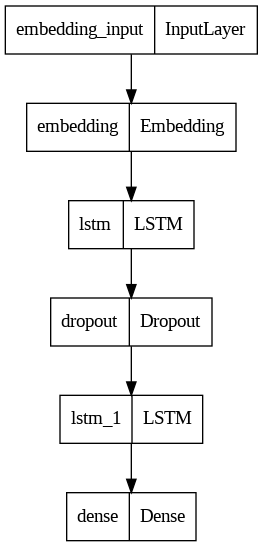

In [10]:
# visualize model structure
ku.plot_model(model, "lstm.png")

**Visualize trianing loss and accuracy**

Here we provide 2 methods to visualize and analyze model.

The first one is to utilize the informazion stored in the History object and visualize the loss information with the API `matplotlib.pyplot`, which provides a MATLAB-like interface. Read more [here](https://matplotlib.org/).

The second methods is to look into the training logs through `tensorboard`, which is a handy and powerful tool for tracking and visualizing metrics such as loss and accuracy during machine learning experiementation. We will talk more about this option in the next week. Read more [here](https://www.tensorflow.org/tensorboard).

In [11]:
import math

Text(0.5, 1.0, 'Accuracy Curves')

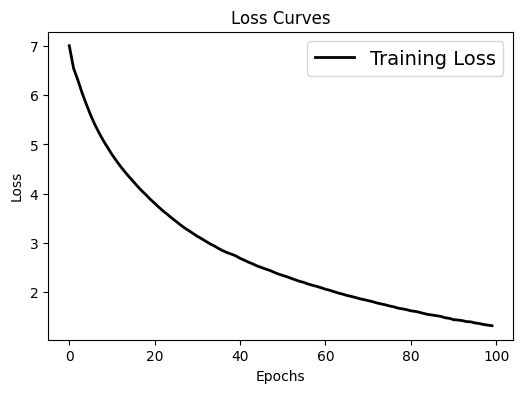

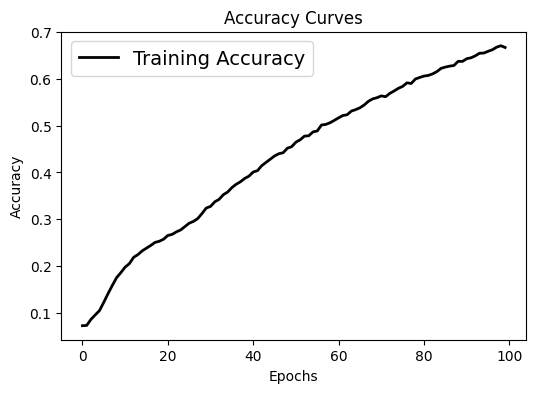

In [14]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.legend(['Training Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.legend(['Training Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

**Save Model**

To avoid retraining models each time before apply the model, a simple solution is to save the model with `model.save`. However, this methods will leave out the training history. `pickle` provides a convenient way to covert the history object to byte stream and dump into a file.

Read more about pickle [here](https://docs.python.org/3/library/pickle.html).

In [15]:
# save model for later use, instead of training it all over again
model.save(f"my_lstm_lm.msl{max_len}.keras")

In [16]:
# save model history in a bianry file with pickle
import pickle

with open(f'trainHistory{max_len}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

**Prediction**

The following funtion `generate_text()` allows you to utilize the trained model and generate the next couple words that are most likely to be the coherent context.

In [17]:
def generate_text(seed_text, next_words, max_sequence_len, model):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		# predicted = model.predict_classes(token_list, verbose=0)
    predicted = np.argmax(model.predict(token_list),axis=1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  return seed_text

In [18]:
print(max_len)

70


In [19]:
# loaded_model = tf.keras.models.load_model("my_lstm_lm.keras")
max_sequence_len = max_len
text = generate_text("what", 4, max_sequence_len, model)
print(text)

1/1 [==============================] - 0s 19ms/step
what countries are under the


# Language modeling with Transformer

We are going to use the pretrained transformer, `GPT-2`, from hugging face just for fun.

`GPT-2` is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts. More precisely, it was trained to guess the next word in sentences.

Transfomers from Hugging Face [Github](https://github.com/huggingface/transformers)

Read more about GPT-2 from Hugging Face [here](https://huggingface.co/gpt2).



In [20]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00


In [21]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)

In [22]:
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]